# Part 5:

## Image Classification  + Transfer Leanring

**Importing necessary libraries**

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

In [3]:
import tensorflow.keras as keras
print(keras.__version__)

2.11.0


In [4]:
import os
import h5py
import random
import tensorflow as tf

from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dropout,Flatten, Convolution2D, MaxPooling2D, Dense, Activation, ZeroPadding2D, GlobalAvgPool2D
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing import image
from tensorflow.keras.losses import BinaryCrossentropy


# fix random seed for reproducibility
np.random.seed(42)

**Downloading Data:**

I am using the tensorflow library to make the dataset efficient for loading into our model.

referrence : [Tensorflow transfer learning](https://www.tensorflow.org/tutorials/images/transfer_learning)

In [5]:
data_dir = "/kaggle/input/face-mask-dataset/data"

In [6]:
batch_size = 32
img_height = 128
img_width  = 128

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
                                          data_dir,
                                          validation_split=0.2,
                                          subset = 'training',
                                          seed=42,
                                          image_size=(img_height, img_width),
                                          batch_size=batch_size
)

Found 7553 files belonging to 2 classes.
Using 6043 files for training.


In [8]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
                                        data_dir,
                                        validation_split = 0.2,
                                        subset = 'validation',
                                        seed = 42,
                                        image_size = (img_height,img_width),
                                        batch_size = batch_size
)

Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


**Visualizing the dataset:**

In [9]:
class_names = train_ds.class_names
class_names

['with_mask', 'without_mask']

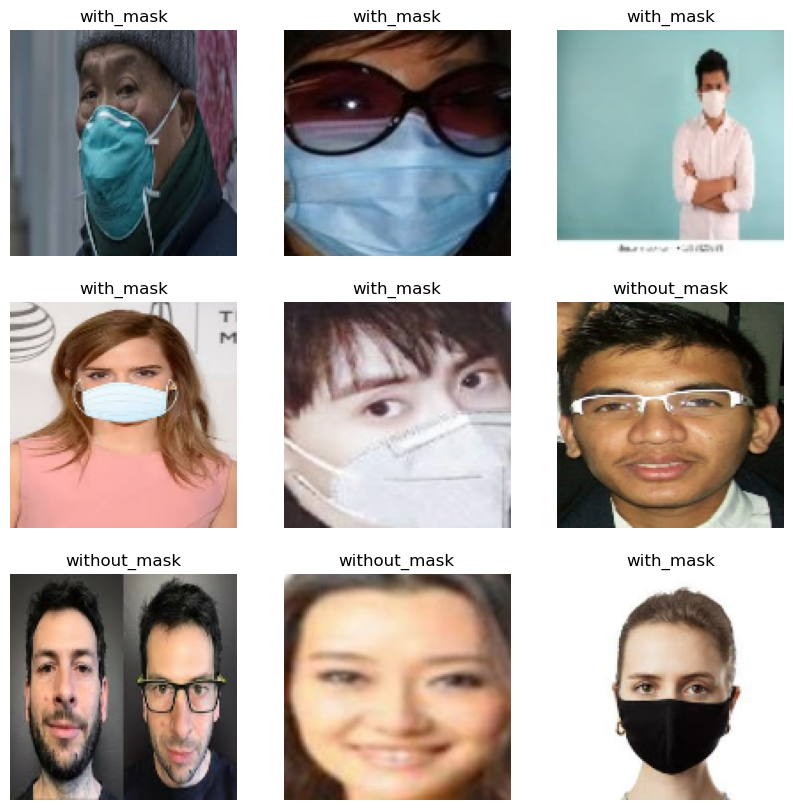

In [10]:
plt.figure(figsize = (10,10))

for images,labels in train_ds.take(1): 
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

**Creating the test dataset:**

In [11]:
#determine number of validation batches and devide it into val and test:
val_batches = tf.data.experimental.cardinality(validation_ds)

In [12]:
test_ds = validation_ds.take(val_batches//5)
validation_ds = validation_ds.skip(val_batches//5)

In [13]:
print(f"Number of test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_ds).numpy()}")

Number of test batches: 9
Number of validation batches: 39


**Configuring the dataset for better performance:**

reference :[Tensorflow data performance guide](https://www.tensorflow.org/guide/data_performance)

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

**Using Data Augmentation:**

reference : [Tensorflow Data Augmentation tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation)

In [15]:
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2)    
])

**Visualizing the data augmentation:**

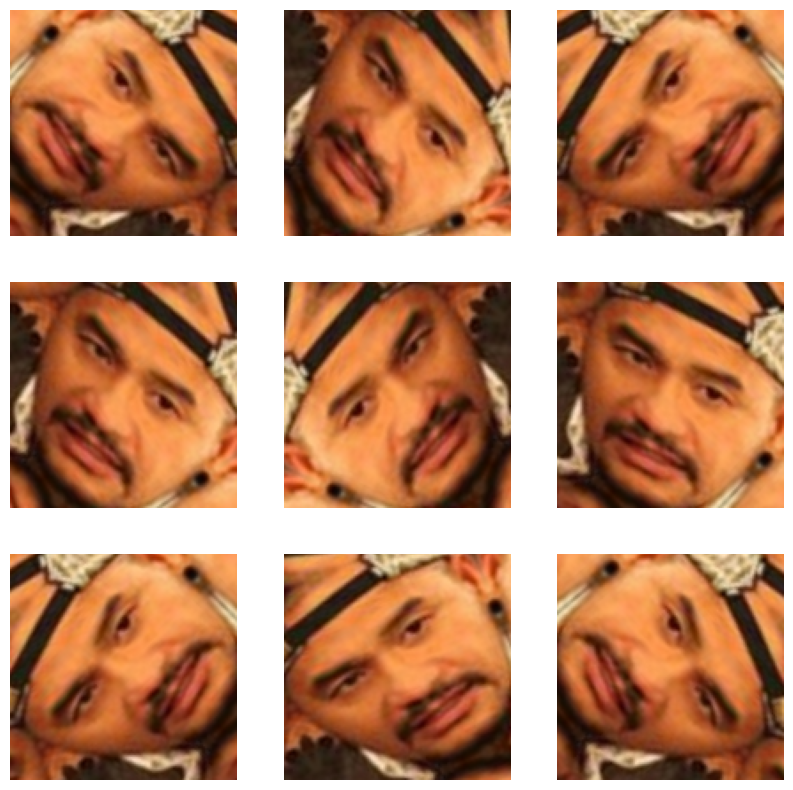

In [16]:
for images, labels in train_ds.take(1):
    img = images[0]
    plt.figure(figsize=  (10,10))
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        aug_img = data_augmentation(img)
        plt.imshow(aug_img/255)
        plt.axis('off')

**Creating the base mode: VGG16**

In [17]:
base_model = tf.keras.applications.vgg16.VGG16( 
                    include_top=False, #we are removing the final layer
                    weights = 'imagenet', #using the pretrained weights from the imagenet dataset
                    input_shape= (img_height,img_width,3)
)

58889256/58889256 [==============================] - 0s 0us/step


**Visualizing the base_model on an example batch of image:**

In [18]:
img_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(img_batch)

print(f"original input shape:{img_batch.shape}")
print(f"output after feature extraction: {feature_batch.shape}")



original input shape:(32, 128, 128, 3)
output after feature extraction: (32, 4, 4, 512)


As we can see the input of shape 128 x 128 x 3  will be converted into 4 x 4 x 512. Now we just have to flatten this and then train a dense model to do the prediction. 

**Feature Extraction:**

Here we freeze the base model from training and just extract the features by passing in our dataset.

In [19]:
base_model.trainable = False

In [20]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

**Adding the Classification layer:**

In [21]:
#to flatten:
global_average_layer = GlobalAvgPool2D()

In [22]:
feature_flatten = global_average_layer(feature_batch)

In [23]:
feature_flatten.shape

TensorShape([32, 512])

As we can see above, after passing through this layer the input will be flattened to a single dimension tensor of 512 and then can be passed to a dense layer.

In [24]:
prediction_sequence = Sequential([
    Dense(256,activation = 'relu'),
    Dropout(0.2),
    Dense(1,activation = 'sigmoid')
    
])

In [25]:
final = prediction_sequence(feature_flatten)
final.shape

TensorShape([32, 1])

As we can see, we will get the final output as either 0 ir 1.

**Putting togather the entire model:**

In [26]:
inputs = Input(shape = (img_height,img_width,3))
x = data_augmentation(inputs)
x = base_model(x , training = False) #to freeze the base model(accounting for batch normalization layers)
x = global_average_layer(x)
outputs = prediction_sequence(x)

model = tf.keras.Model(inputs, outputs)

**Compiling the model:**

In [27]:
model.compile(
    optimizer = Adam(learning_rate = 0.0001),
    loss      = BinaryCrossentropy(),
    metrics   = ['accuracy']
)

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (128, 128, 3)             0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 sequential_1 (Sequential)   (None, 1)                 131585    
                                                                 
Total params: 14,846,273
Trainable params: 131,585
Non-trainable params: 14,714,688
___________________________________________

As we can see form the model summary above, only the classification layers that we added on top of VGG16 are trainable. The rest just act as feature extraction!

**Initial Training:**

In [29]:
epochs1 = 10
history = model.fit(train_ds,epochs = epochs1,validation_data=validation_ds)

Epoch 1/10
189/189 [==============================] - 41s 185ms/step - loss: 0.9882 - accuracy: 0.7900 - val_loss: 0.2051 - val_accuracy: 0.9460
Epoch 2/10
189/189 [==============================] - 30s 155ms/step - loss: 0.4850 - accuracy: 0.8785 - val_loss: 0.1608 - val_accuracy: 0.9542
Epoch 3/10
189/189 [==============================] - 29s 153ms/step - loss: 0.4080 - accuracy: 0.8931 - val_loss: 0.1433 - val_accuracy: 0.9624
Epoch 4/10
189/189 [==============================] - 29s 151ms/step - loss: 0.3166 - accuracy: 0.9110 - val_loss: 0.1369 - val_accuracy: 0.9640
Epoch 5/10
189/189 [==============================] - 29s 152ms/step - loss: 0.2947 - accuracy: 0.9125 - val_loss: 0.1300 - val_accuracy: 0.9656
Epoch 6/10
189/189 [==============================] - 28s 148ms/step - loss: 0.2677 - accuracy: 0.9191 - val_loss: 0.1087 - val_accuracy: 0.9730
Epoch 7/10
189/189 [==============================] - 29s 150ms/step - loss: 0.2434 - accuracy: 0.9298 - val_loss: 0.1109 - val_ac

**Plotting training and validation parameters:**

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

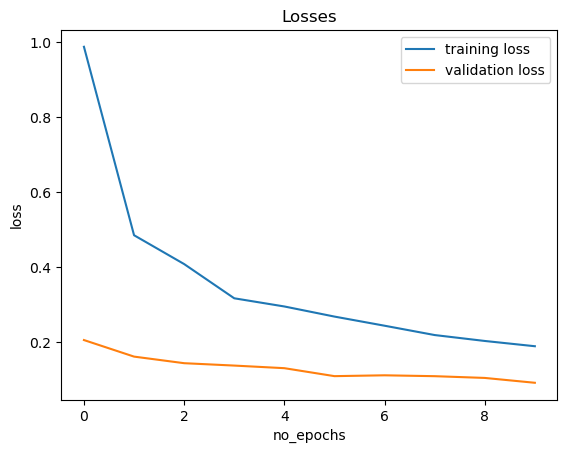

In [31]:
plt.plot(loss)
plt.plot(val_loss)
plt.title("Losses")
plt.xlabel("no_epochs")
plt.ylabel("loss")
plt.legend(["training loss","validation loss"])

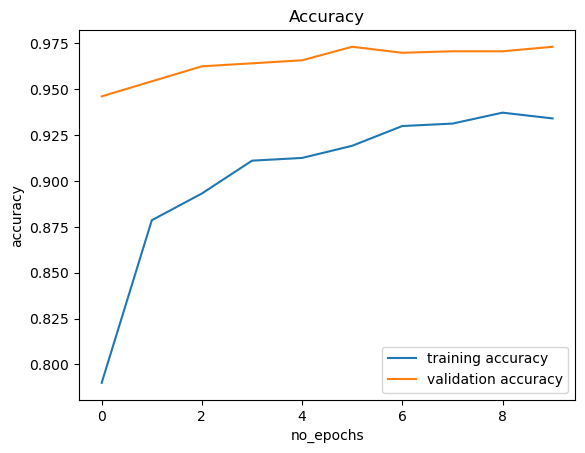

In [32]:
plt.plot(acc)
plt.plot(val_acc)
plt.title("Accuracy")
plt.xlabel("no_epochs")
plt.ylabel("accuracy")
plt.legend(["training accuracy","validation accuracy"])

Here the validation metrics are better because during validation there are no regularizations like batch normalization and dropouts! 

**Fine Tuning:**

Here we will fine the top layers of the VGG16 model itself. The lower layers are more generalized ones but the higher layers are more specialized and are more specific to the dataset. So we will fine tune the model by making these layers trainable.

In [33]:
base_model.trainable = True

We will look at the number of layers in the base model and fine tune only the last 10% of the layers

In [34]:
number_of_layers = len(base_model.layers)
fine_tune_from = int(0.9*number_of_layers)

#we freeze all the layers before this one:
for layer in base_model.layers[:fine_tune_from]:
    layer.trainable = False
    

Now we compile the model again. Here it is important to use lower learning rate since it is an already trained model!

In [35]:
model.compile(
    optimizer = RMSprop(learning_rate = 0.00001),
    loss = BinaryCrossentropy(),
    metrics = ["accuracy"]
)

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (128, 128, 3)             0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 sequential_1 (Sequential)   (None, 1)                 131585    
                                                                 
Total params: 14,846,273
Trainable params: 2,491,393
Non-trainable params: 12,354,880
_________________________________________

As we can see now the number of trainable parameters have increased

In [37]:
print("Number of trainable layers:",len(model.trainable_variables))

Number of trainable layers: 6


Continuing the training

In [38]:
tune_epochs = 10
total_epochs = tune_epochs + epochs1

history_tune = model.fit(
                    train_ds,
                    epochs = total_epochs,
                    initial_epoch = history.epoch[-1],
                    validation_data= validation_ds
)

Epoch 10/20
189/189 [==============================] - 34s 155ms/step - loss: 0.1841 - accuracy: 0.9378 - val_loss: 0.1057 - val_accuracy: 0.9738
Epoch 11/20
189/189 [==============================] - 29s 152ms/step - loss: 0.1523 - accuracy: 0.9477 - val_loss: 0.0886 - val_accuracy: 0.9755
Epoch 12/20
189/189 [==============================] - 29s 152ms/step - loss: 0.1274 - accuracy: 0.9578 - val_loss: 0.0896 - val_accuracy: 0.9738
Epoch 13/20
189/189 [==============================] - 29s 153ms/step - loss: 0.1198 - accuracy: 0.9626 - val_loss: 0.0940 - val_accuracy: 0.9755
Epoch 14/20
189/189 [==============================] - 29s 149ms/step - loss: 0.1073 - accuracy: 0.9646 - val_loss: 0.0824 - val_accuracy: 0.9779
Epoch 15/20
189/189 [==============================] - 29s 152ms/step - loss: 0.1022 - accuracy: 0.9634 - val_loss: 0.0820 - val_accuracy: 0.9779
Epoch 16/20
189/189 [==============================] - 29s 152ms/step - loss: 0.0870 - accuracy: 0.9725 - val_loss: 0.0810 -

**Model Evaluation:**

In [39]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test accuracy is : {accuracy}")

9/9 [==============================] - 1s 47ms/step - loss: 0.0545 - accuracy: 0.9861
Test accuracy is : 0.9861111044883728


**Model Prediction:**

In [40]:
#retreiving images from the test dataset:
images,labels = next(iter(test_ds))

In [41]:
#prediction:
pred = model.predict_on_batch(images)

In [42]:
#thresholding the predictions
for i in range(len(pred)):
    if pred[i] > 0.5:
        pred[i] = 1
    else:
        pred[i] = 0

In [43]:
pred = pred.astype("uint8")

In [44]:
labels = labels.numpy().astype("uint8")

**Plotting:**

In [45]:
class_names

['with_mask', 'without_mask']

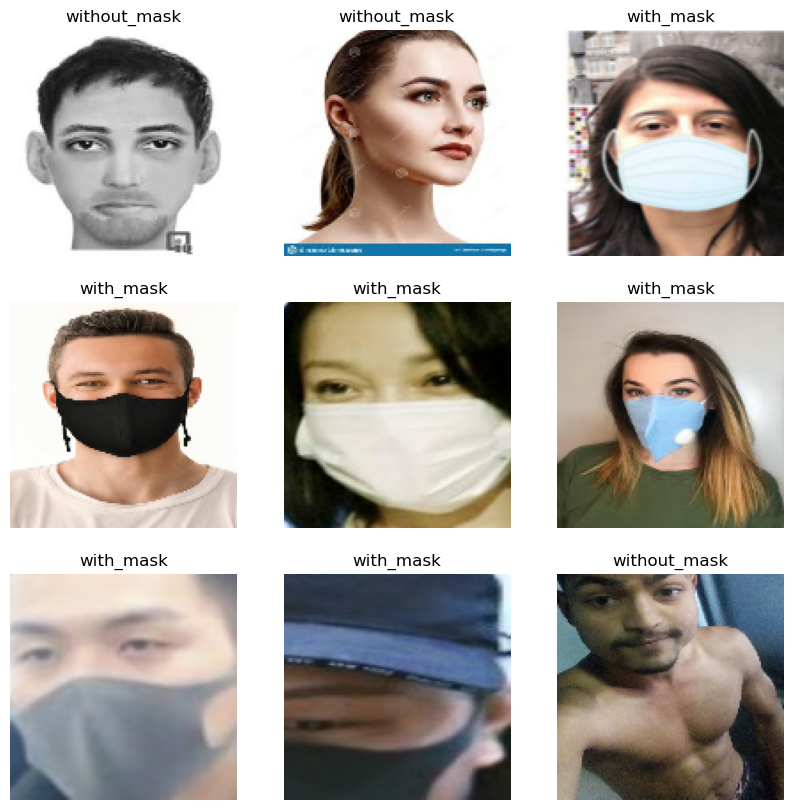

In [46]:
plt.figure(figsize =(10,10))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i]/255)
    plt.title(class_names[pred[i][0]])
    plt.axis("off")
    

As we can see our model performs really well!

**Finally looking at the confusion matrix:**

In [47]:
conf_matrix = tf.math.confusion_matrix(labels,pred)

In [48]:
df = pd.DataFrame(conf_matrix.numpy(),index = class_names,columns = class_names)

In [49]:
df

,with_mask,without_mask
with_mask,17,0
without_mask,0,15


Our model performs really well in all the metrics